In [1]:
import sympy as sp
import numpy as np
import control
from control import TransferFunction
from control.matlab import step , impulse
import matplotlib
import scipy.linalg 
from matplotlib import pylab, mlab
import matplotlib.pylab as pylab

# forces plots to appear in the ipython notebook
%matplotlib inline

from scipy.integrate import odeint
from pylab import plot,xlabel,ylabel,title,legend,figure,subplots

from pylab import cos, pi, arange, sqrt, pi, array

from numpy import ma
import matplotlib.pyplot as plt

from IPython.display import display
from IPython.core.pylabtools import figsize, getfigs
import IPython
import math
sp.init_printing()

/home/djole/.local/lib/python2.7/site-packages/scipy/linalg/basic.py:17: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._solve_toeplitz import levinson
/home/djole/.local/lib/python2.7/site-packages/scipy/linalg/__init__.py:207: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._decomp_update import *
/home/djole/.local/lib/python2.7/site-packages/scipy/special/__init__.py:640: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._ufuncs import *
/home/djole/.local/lib/python2.7/site-packages/scipy/special/_ellip_harm.py:7: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._ellip_harm_2 import _ellipsoid, _ellipsoid_norm
/home/djole/.local/lib/python2.7/site-packages/scipy/signal/_max_len_seq.py:8: RuntimeWarning: numpy.dtype size changed, may indicate binary in

In [2]:
class ABAG:
    def __init__(abag, delta_gain, delta_bias, min_gain, alpha, e_b, e_g, reverse_error):
        abag.delta_gain = delta_gain
        abag.delta_bias = delta_bias
        abag.min_gain = min_gain
        abag.alpha = alpha
        abag.e_b = e_b
        abag.e_g = e_g
        abag.gain = 0.0
        abag.bias = 0.0
        abag.e_bar = 0.0
        abag.reverse_error = reverse_error
        
    def control(abag, y_m, y_d):
        if not abag.reverse_error:
            if (y_m < y_d): 
                abag.e_bar = abag.alpha * abag.e_bar + (1.0 - abag.alpha)
            else: 
                abag.e_bar = abag.alpha * abag.e_bar - (1.0 - abag.alpha)
        else:
            if (y_m > y_d): 
                abag.e_bar = abag.alpha * abag.e_bar + (1.0 - abag.alpha)
            else: 
                abag.e_bar = abag.alpha * abag.e_bar - (1.0 - abag.alpha)
    
        abag.bias = abag.saturate(abag.bias + abag.delta_bias * abag.xi_bias(abag.e_bar))
        abag.gain = abag.saturate(abag.gain + abag.delta_gain * abag.xi_gain(abag.e_bar))

        u = 0.0
        if not abag.reverse_error:
            if (y_m < y_d): 
                u = abag.saturate(abag.bias + abag.gain)
            else:
                u = abag.saturate(abag.bias - abag.gain)
        else:
            if (y_m > y_d): 
                u = abag.saturate(abag.bias + abag.gain)
            else:
                u = abag.saturate(abag.bias - abag.gain)

        return u


    def saturate(abag, value):
        if (value < 0.0):
            return 0.0
        elif (value > 1.0):
            return 1.0
        else:
            return value
        
    def xi_bias(abag, e_bar):
        if (e_bar < -abag.e_b): 
            return -1.0
        elif (e_bar > abag.e_b): 
            return 1.0
        else: 
            return 0.0
        
    def xi_gain(abag, e_bar):
        if (e_bar < -abag.e_g):
            return 1.0
        elif (e_bar > abag.e_g):
            return 1.0
        else:
            return -1.0     

In [3]:
class Plant:
    def __init__(plant, damping, mass, gravity):
        plant.damping = damping
        plant.mass = mass
        plant.gravity = gravity
        
    def massDamper(plant, state, t, u, m, c):
        '''
        k = spring constant
        m = mass
        c = damping coefficient

        for a mass,spring
            xdd = (-k*x)/m + g
        for a mass, spring, damper 
            xdd = -k*x/m - c*xd/m - g
        for a mass, spring, damper with forcing function
            xdd = -(k*x)/m - (c*xd)/m - g + f/m
        '''

        '''
        for a mass, damper, no gravity with forcing function
            xdd = (-c*xd)/m + u/m
        '''

        # state vector
        x, xd = state # displacement x and velocity x'

        # compute acceleration xdd = x''
        xdd = u/m - c*xd/m
        
        return [xd, xdd]
    
    def massGravity(plant, state, t, u, m, g):
        '''
            Point mass falling or rising w.t.r. ground. 
            Forces influencing: * external force pushing upwards
                                * gravity pushing downwards.
        '''

        # state vector
        x, xd = state # displacement x and velocity x'

        # compute acceleration xdd = x''
        xdd = u/m - g
        return [xd, xdd]
    
    def simulate_MG(plant, u, state):
        '''
        Integrate/simulate only for one step.
        Maybe we should integrate for more than one step? 
        In that case, the ABAG controller would not run at same frequency as change/update of dynamics occur? 
        '''
        state0 = state  #initial conditions [x0 , v0] 
        t0 = 0.0  # initial time
        step = 0.001  # step
        tf = step * 4 # final time
        t = arange(t0, tf, step)
        new_state = odeint(plant.massGravity, state0, t, args = (u, plant.mass, plant.gravity), printmessg = True)
        x = new_state[:, [0]]
        xd = new_state[:, [1]]
        new_state = np.squeeze(np.array([x[-1], xd[-1]])) 
        return new_state
    
    def simulate_MD(plant, u, state):
        '''
        Integrate/simulate only for one step.
        '''
        state0 = state  #initial conditions [x0 , v0] 
        t0 = 0.0  # initial time
        step = 0.001  # step
        tf = step * 2 # final time
        t = arange(t0, tf, step)
        new_state = odeint(plant.massDamper, state0, t, args = (u, plant.mass, plant.damping), printmessg = True)
        x = new_state[:, [0]]
        xd = new_state[:, [1]]
        new_state = np.squeeze(np.array([x[-1], xd[-1]])) 
        return new_state
    
    def simulate_generic(plant, u, state):
        
        x, y_m = state
        y_dot = plant.damping - plant.mass * u
        y_m = y_m + y_dot
        
        if(y_m < 0.0):
            y_m = 0.0 

        return [x, y_m]    

Elements of step function: [50.         45.19686487 45.31994352 50.24300347 54.91683307]


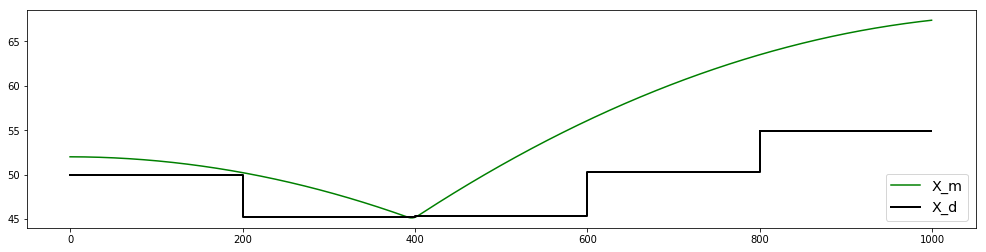

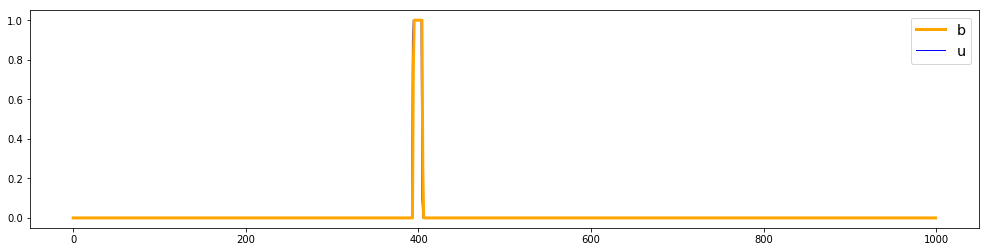

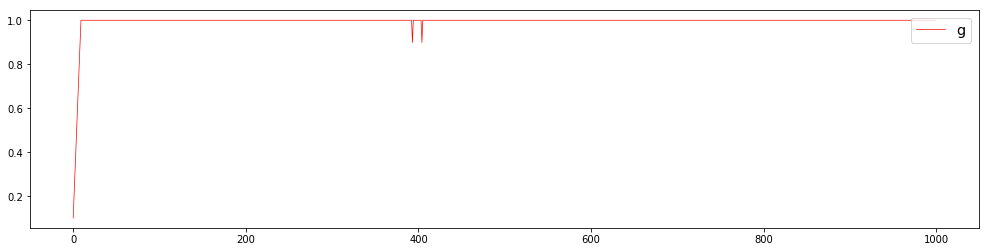

In [6]:
#########################################################################
# Tesing code for Mass-Gravity plant
#########################################################################

x_m = 52 #initial height [m]

max_iteration = 1000
step_change = 200

samples = np.arange(0, max_iteration, step_change)
y0 = np.sin(samples)
x_d = y0.copy() * 5.5 + 50
num_samples = np.size(x_d)

print("Elements of step function: " + str(x_d))

abag = ABAG(delta_gain = 0.101101953, 
            delta_bias = 0.7511976, 
            min_gain = 0.000976, 
            alpha = 0.45, 
            e_b = 0.45, 
            e_g = 0.50,
            reverse_error = False)

plant = Plant(damping = 0.01, mass = 0.005, gravity = 9.81)

measurements = []
bias = []
gain = []
command = []
state = [x_m, 0.0]

for n in range(num_samples):
    for i in range(step_change):
        u = abag.control(state[0], x_d[n])
        bias.append(abag.bias)
        gain.append(abag.gain)
        command.append(u)
        state = plant.simulate_MG(u*5, state)
        measurements.append(state[0])

plt.figure(figsize = (17,4))
plt.plot(np.array(measurements), c = 'green', label='X_m', zorder=2)

if not num_samples == 1:
    plt.step(samples, x_d, label='X_d', linewidth = 2, where='post', color = 'black')
    l = plt.hlines(xmin = 800, xmax = 1000, y = x_d[-1], color = 'black',linewidth=2, zorder=1)
else:
    l = plt.axhline(y = x_d[0], label='X_d', c = 'black', linewidth=2)
    
plt.legend(loc=4, fontsize = 'x-large')
plt.show()

plt.figure(figsize = (17,4))
plt.plot(np.array(bias), c = 'orange', label='b', linewidth=3, zorder=3)
plt.plot(np.array(command), c = 'blue', label='u', linewidth=1, zorder=2)
plt.legend(loc=1, fontsize = 'x-large')
plt.show()

plt.figure(figsize = (17,4))
plt.plot(np.array(gain), c = 'red', label='g', linewidth=0.7, zorder=1)
plt.legend(loc=1, fontsize = 'x-large')
plt.show()

Elements of step function: [50.         45.19686487 45.31994352 50.24300347 54.91683307]


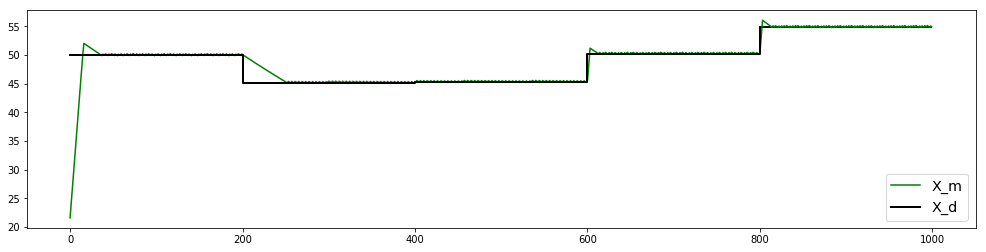

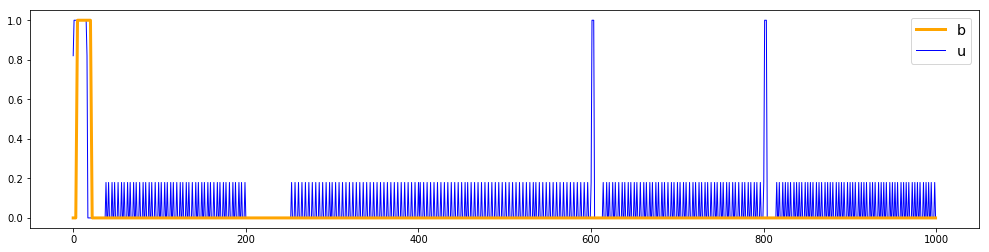

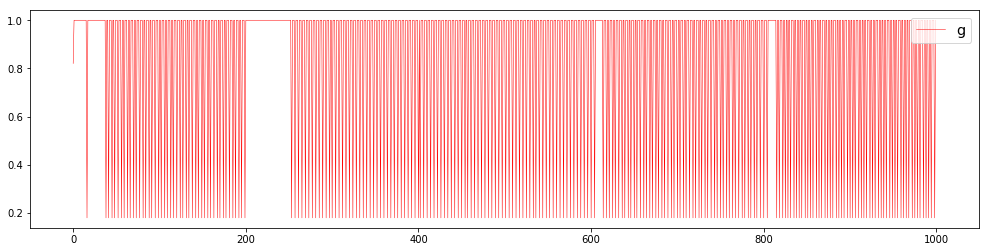

In [7]:
#########################################################################
# Tesing code for Mass-Damper plant
#########################################################################

x_m = 20.0 #initial frequency Hz

max_iteration = 1000
step_change = 200

samples = np.arange(0, max_iteration, step_change)
y0 = np.sin(samples)
x_d = y0.copy() * 5.5 + 50
num_samples = np.size(x_d)

print("Elements of step function: " + str(x_d))

abag = ABAG(delta_gain = 0.8205953, 
            delta_bias = 0.507976, 
            min_gain = 0.000976, 
            alpha = 0.45, 
            e_b = 0.98, 
            e_g = 0.35,
            reverse_error = False)

plant = Plant(damping = 0.01, mass = 0.005, gravity = 9.81)

measurements = []
bias = []
gain = []
command = []
state = [0.0, x_m]

for n in range(num_samples):
    for i in range(step_change):
        u = abag.control(state[1], x_d[n])
        bias.append(abag.bias)
        gain.append(abag.gain)
        command.append(u)
        state = plant.simulate_MD(u*10, state)
        measurements.append(state[1])

plt.figure(figsize = (17,4))
plt.plot(np.array(measurements), c = 'green', label='X_m', zorder=2)

if not num_samples == 1:
    plt.step(samples, x_d, label='X_d', linewidth = 2, where='post', color = 'black')
    l = plt.hlines(xmin = 800, xmax = 1000, y = x_d[-1], color = 'black',linewidth=2, zorder=1)
else:
    l = plt.axhline(y = x_d[0], label='X_d', c = 'black', linewidth=2)
    
plt.legend(loc=4, fontsize = 'x-large')
plt.show()

plt.figure(figsize = (17,4))
plt.plot(np.array(bias), c = 'orange', label='b', linewidth=3, zorder=3)
plt.plot(np.array(command), c = 'blue', label='u', linewidth=1, zorder=2)
plt.legend(loc=1, fontsize = 'x-large')
plt.show()

plt.figure(figsize = (17,4))
plt.plot(np.array(gain), c = 'red', label='g', linewidth=0.5, zorder=1)
plt.legend(loc=1, fontsize = 'x-large')
plt.show()

Elements of step function: [50.         45.19686487 45.31994352 50.24300347 54.91683307]


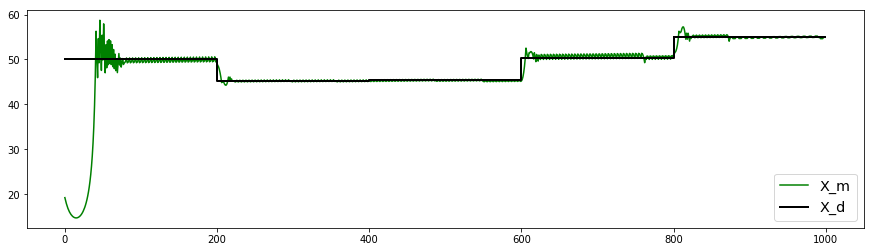

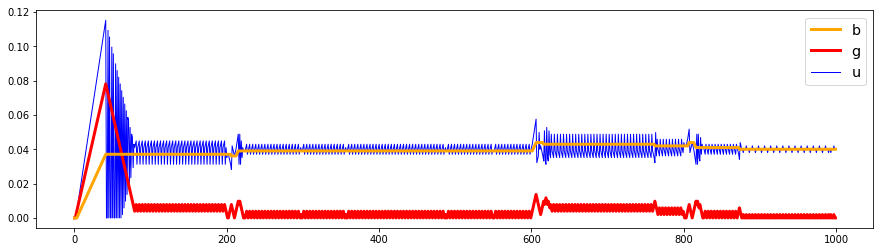

In [8]:
#########################################################################
# Tesing code for Generic plant
#########################################################################

x = 20.0 #initial freq 20Hz
y_m = 1/x

max_iteration = 1000
step_change = 200

samples = np.arange(0, max_iteration, step_change)
y0 = np.sin(samples)
x_d = y0.copy() * 5.5 + 50
num_samples = np.size(x_d)

print("Elements of step function: " + str(x_d))

abag = ABAG(delta_gain = 0.001953, 
            delta_bias = 0.000976, 
            min_gain = 0.000976, 
            alpha = 0.75, 
            e_b = 0.75, 
            e_g = 0.5,
            reverse_error = True)

plant = Plant(damping = 0.002, mass = 0.05, gravity = 9.81)

measurements = []
bias = []
gain = []
command = []
state = [0.0, y_m]

for n in range(num_samples):
    y_d = 1/x_d[n]
    for i in range(step_change):
        u = abag.control(state[1], y_d)
        bias.append(abag.bias)
        gain.append(abag.gain)
        command.append(u)
        state = plant.simulate_generic(u, state)
        measurements.append(1/state[1])

plt.figure(figsize = (15,4))
plt.plot(np.array(measurements), c = 'green', label='X_m', zorder=1)

if not num_samples == 1:
    plt.step(samples, x_d, label='X_d', linewidth = 2, where='post', color = 'black')
    l = plt.hlines(xmin = 800, xmax = 1000, y = x_d[-1], color = 'black', linewidth=2, zorder=2)
else:
    l = plt.axhline(y = x_d[0], label='X_d', c = 'black', linewidth=2)
    
plt.legend(loc=4, fontsize = 'x-large')
plt.show()

plt.figure(figsize = (15,4))
plt.plot(np.array(bias), c = 'orange', label='b', linewidth=3, zorder=3)
plt.plot(np.array(gain), c = 'red', label='g', linewidth=3, zorder=2)
plt.plot(np.array(command), c = 'blue', label='u', linewidth=1, zorder=1)
plt.legend(loc=1, fontsize = 'x-large')
plt.show()

In [ ]:
#########################################################################
# Tesing code for PID plant
#########################################################################

x = 20.0 #initial freq 20Hz
y_m = 1.0/x

max_iteration = 1000
step_change = 200
# x_step = [0, 200, 400, 600] 
# y_step = [50.0, 45.2, 58.3, 62.1]
samples = np.arange(0, max_iteration, step_change)
print(samples)
y0 = np.sin(samples)
x_d = y0.copy() * 5.5 + 50
num_samples = size(x_d)

print("Elements of step function: ")
print(x_d)

abag = ABAG(delta_gain = 0.001953, 
            delta_bias = 0.000976, 
            min_gain = 0.000976, 
            alpha = 0.75, 
            e_b = 0.75, 
            e_g = 0.5)

plant = Plant(damping = 0.002, mass = 0.05)

measurements = []

for n in range(num_samples):
    y_d = 1.0/x_d[n]
    for i in range(step_change):
        u = abag.control(y_m, y_d)
        y_m = plant.simulate_generic(u, y_m)
        measurements.append(1/y_m)

plt.figure(figsize = (9,8))
plt.plot(np.array(measurements), c = 'red', label='X_m')

if not num_samples == 1:
    plt.step(samples, x_d, label='X_d', linewidth = 2, where='post')
else:
    l = plt.axhline(y = x_d[0], label='X_d', c = 'blue', linewidth=2)
    
plt.ylim([0, 70])
plt.legend(loc=1, fontsize = 'x-large')
plt.show()

damping = 0.002
mass = 0.05
plant1 = control.TransferFunction([1],[mass, damping, 0]) 
Kp = 50
Ki = 100
Kd = 10
controller = control.TransferFunction([Kd,Kp,Ki],[1,0])
control_loop = control.series(controller, plant1) 
sys = control.feedback(control_loop)
out,time = control.matlab.step(sys) 
plt.plot(time,out, c = 'red')
plt.plot(time,np.ones(len(time)),"blue")

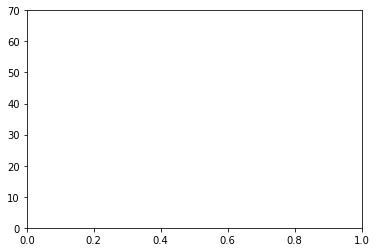

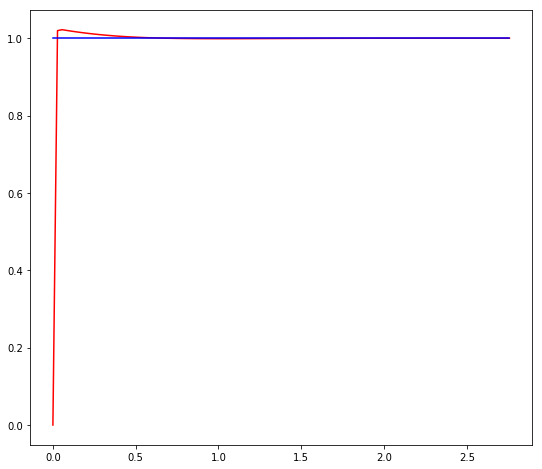

In [36]:
damping = 0.002
mass = 0.05
Kp = 50
Ki = 100
Kd = 10
plant = control.TransferFunction([1],[mass, damping, 0]) 
PID = control.TransferFunction([Kd,Kp,Ki],[1,0])
control_loop = control.series(PID, plant) 
sys = control.feedback(control_loop)
out,time = control.matlab.step(sys) 
plt.ylim([0, 70])
plt.figure(figsize = (9,8))
plt.plot(time,out, c = 'red')
plt.plot(time,np.ones(len(time)),"blue")